In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import math
import matplotlib.pyplot as plt
import torch.nn.init as init
import time

In [2]:
def np_to_torch(arr):
    
    arr = torch.FloatTensor(arr)
    arr = arr.unsqueeze(-1)
    arr = arr.clone().detach().requires_grad_(True)
    
    return arr

def x_train_data(N_x, x_l, x_r, N_bc, s, t_test, del_t):
    
    x_train = np.linspace(x_l,x_r,N_x)   

    for i in range(N_x):
        if x_train[i]>s:
            break

#     x_bc1 = np.ones(N_bc)*x_l
#     x_train = np.concatenate((x_train, x_bc1),0)
    x_train = np_to_torch(x_train)
    N_xl = torch.sum( torch.where(x_train == x_l,1,0) ).detach().numpy().item()
    
    return x_train, N_xl, i

def initial_temp(N_x, N_bc, T_l, T_r, N_x_test, N_s, N_s_test):
    
    T_prev_1 = np.concatenate((np.linspace(T_l,T_r,N_s), np.ones(N_x - N_s)*T_r),0)
    T_prev = np_to_torch(T_prev_1)
#     T_prev_2 = np.ones(N_bc)*T_l
#     T_prev = np.concatenate((T_prev_1, T_prev_2),0)
#     T_prev = np_to_torch(T_prev)
    
    T_test_prev = np.concatenate((np.linspace(T_l,T_r,N_s_test), np.ones(N_x_test - N_s)*T_r),0)
    T_test_prev = np.reshape(T_test_prev,(N_x_test, 1))
    
    return T_prev, T_test_prev

def initial_interface(N, s):

    s_interface = torch.full((N, 1), s)
    s_interface = s_interface.clone().detach().requires_grad_(True)
    
    return s_interface, s_interface
            
def xavier_init(m):
    if isinstance(m, nn.Linear):
        init.xavier_normal_(m.weight)
        if m.bias is not None:
            init.constant_(m.bias, 0)
    
class ANN(nn.Module):
    def __init__(self, layer_size):
        super(ANN, self).__init__()
        
        # Fully conected model
        modules = []
        for i in range(len(layer_size) - 2):
            modules.append(nn.Linear(layer_size[i], layer_size[i+1]))  
            modules.append(nn.Tanh())
        modules.append(nn.Linear(layer_size[-2], layer_size[-1])) 
#         modules.append(nn.ReLU())

        self.fc = nn.Sequential(*modules)
        for layer in self.fc.modules():
            if isinstance(layer, nn.Linear):
                 layer.weight.data.normal_(mean=0, std=0.2)
#         self.fc.apply(xavier_init)
        
    def forward(self, x_train, k2, del_t, s_ini, t_test, dTsds_prev):
        op = self.fc( x_train )
        op_x = torch.autograd.grad(op, x_train, grad_outputs=torch.ones_like(op), create_graph=True)[0]
        op_x2 = torch.autograd.grad(op_x, x_train, grad_outputs=torch.ones_like(op_x), create_graph=True)[0]
        
        op_s = self.fc( s_ini )
        op_s_x = torch.autograd.grad(op_s, s_ini, grad_outputs=torch.ones_like(op_s), create_graph=True)[0]
        
        c_prev = 0
        c_new = 1 - c_prev
            
        s_new = s_ini - del_t*k2*(c_new*op_s_x + c_prev*dTsds_prev)
        op_s_new = self.fc( s_new )
        op_s_new_x = torch.autograd.grad(op_s_new, s_new, grad_outputs=torch.ones_like(op_s_new), create_graph=True)[0]
        op_s_new_x2 = torch.autograd.grad(op_s_new_x, s_new, grad_outputs=torch.ones_like(op_s_new), create_graph=True)[0]

        return op, op_x2, op_s_new, s_new, op_s_x, op_s_new_x2
    
def get_loss(x_train, k1, k2, N_tot, T_l, T_r, N_xl, x_l, x_r, T_prev, del_t, t_test, s_ini, dTsds_prev):
    
    mse = nn.MSELoss(reduction='sum')
    w1 = 1
    w2 = 1
    w3 = 1
        
#     if(t_test == del_t):
#         w2 = 4
        
    T, d2Tdx2, Ts, s_new, _, d2Tdx2_s_new  = model(x_train, k2, del_t, s_ini, t_test, dTsds_prev)
    N1 = torch.sum(torch.where(x_train <= s_new,1,0)).detach().numpy().item()
    eq1 = w1*( torch.sum( torch.square( torch.mul(torch.where(x_train <= s_new,1,0),T - T_prev - del_t*k1*d2Tdx2 ) ) ) )/(N1)
    bc1 = w2*torch.sum( torch.square( torch.mul(torch.where(x_train == x_l,1,0),(T - T_l)) ) )/(N_xl)
    bc2 = w3*torch.sum( torch.square( T_r - Ts ) )

    loss = eq1 + bc1 + bc2   
    
    return loss, eq1, bc1, bc2

def print_loss(epoch, loss, eq1, bc1, bc2):
    print('epoch = ',epoch)
    print('loss = ',loss.detach().numpy())
    print('eq1_loss = ',eq1.detach().numpy())
    print('bc1_loss = ',bc1.detach().numpy())
    print('bc2_loss = ',bc2.detach().numpy())

def interface_identifier(y_pred, T_r, N, x_test, s):
    
    for i in range(N):
        if x_test[i]>s:
            break
            
    for j in range(i,N):
        y_pred[j] = T_r

    return y_pred, s

def lamb_analytical(k1, k2):
    x = []
    er = []
    cnt = 0
    for i in np.arange(0.1, 5, 0.001):
        x.append(i)
        er.append(math.erf(x[-1]))
        cnt = cnt+1

    x = np.array(x)
    er = np.array(er)
    y =[]
    y = np.exp(-x*x)/(er*math.sqrt(math.pi))-x*k1/k2

    for i in range(1,cnt):
        if(y[i]*y[i-1]<0):
            lam = x[i]
            break
    
    return lam

def analytical(N_x_test, x_test, t_test, T_r, k1, k2, T_l):

    x_test = x_test.detach().numpy()
    y_an = np.zeros((N_x_test, 1))
    lam = lamb_analytical(k1, k2)
    s = np.sqrt(k1*t_test)*2*lam
    
    for j in range(N_x_test):
        if(x_test[j]<s):
            y_an[j] = T_l - T_l*math.erf( x_test[j]/( 2*np.sqrt(k1*t_test) ) )/ math.erf(lam) 
        else:
            y_an[j] = T_r
            
    y_an = np.reshape(y_an, (N_x_test, 1))
    
    return y_an, s
    
def train_model(model, optimiser1, epochs, T_r, T_l, k1, k2, N_x, x_l, x_r, N_t, N_bc, accuracy_cap, N_x_test, del_t, s_initial):
    
    loss_store = []
    T_store_pred = []
    s_store_pred = []
    T_store_an = []
    s_store_an = []
    t_store = []
    mse = nn.MSELoss(reduction='sum')
    model.train()  
    
#     N_tot = N_x + N_bc
    N_tot = N_x
    print("N_tot = ", N_tot)
    
    t_test = 0
    
    t_store.append(0)
    s_store_an.append(0)
    for i in range(N_t):
        
        t_test = t_test + del_t
        t_store.append(t_test)
        print("t = ", t_test)
        print(" ")
        
        if(i==0):
            x_train, N_xl, N_s = x_train_data(N_x, x_l, x_r, N_bc, s_initial, t_test, del_t)
            print("Ns = ", N_s)
            T_prev, _ = initial_temp(N_x, N_bc, T_l, T_r, N_x_test, N_s, N_s)
            s_prev, _ = initial_interface(1, s_initial)
            T_store_pred.append(T_prev.detach().numpy())
            s_store_pred.append(s_prev.detach().numpy())
            slope = (T_r - T_l)/s_initial
            print("slope = ", slope)
            dTsds_prev =torch.FloatTensor( np.ones((1, 1))*slope )
        print("slope at interface = ", dTsds_prev)
#         print(T_prev)
        
        for epoch in range(epochs):
            
            #Backpropogation and optimisation
            loss, eq1, bc1, bc2 = get_loss(x_train, k1, k2, N_tot, T_l, T_r, N_xl, x_l, x_r, T_prev, del_t, t_test, s_prev, dTsds_prev)
            optimiser1.zero_grad()
            loss.backward()
            optimiser1.step()  
            loss_store.append(loss.detach().numpy())
            
            if epoch%2000==0:
                print_loss(epoch, loss, eq1, bc1, bc2)
                print("")

            if loss<0.0004 :
                print("loss limit attained, epoch = ", epoch)
                print_loss(epoch, loss, eq1, bc1, bc2)
                print("")
                break
                    
        # Store the results after each time step
        T_prev,_,_,s_prev,dTsds_prev,_ = model(x_train, k2, del_t, s_prev, t_test, dTsds_prev) 
        dTsds_prev = dTsds_prev.clone().detach().requires_grad_(False)
        T_prev = T_prev.detach().numpy()
        T_prev, _ = interface_identifier(T_prev, T_r, N_tot, x_train.detach().numpy(), s_prev[0][0].detach().numpy())
        s_prev = s_prev.detach().numpy()
        print("interface_PINN = ", s_prev[0][0])
        T_an, s_an = analytical(N_x, x_train, t_test, T_r, k1, k2, T_l)
        print("interface_Analytical = ", s_an)
        
        T_store_pred.append(T_prev)
        
        T_store_an.append(T_an)
        s_store_pred.append(s_prev)
        s_store_an.append(s_an)
        
        T_prev = torch.FloatTensor(T_store_pred[-1]).clone().detach().requires_grad_(False)
        s_prev = torch.FloatTensor(s_store_pred[-1]).clone().detach().requires_grad_(True)
        
        print("broke inner loop")
        print("")

    return loss_store, T_store_pred, T_store_an, x_train, s_store_pred, s_store_an, t_store

In [3]:
N_x = 3001
N_bc = 30
N_t = 100
del_t = 0.001
x_l = 0
x_r = 0.28
T_r = 0
T_l = 0.5
t_i = 0
accuracy_cap = 0.00035
N_x_test = 251
s_initial = 0.0015

# Neural network params
layer_size = [1, 3, 3, 1]

# material params
k1 = 0.01
k2 = 0.00912

# Training data and initial data
model = ANN(layer_size)
print(model)
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total trainable parameters in the model:", total_trainable_params)

# # Setup Loss function and Optimiser
lr = 1e-4
epochs = 90001
optimiser1 = torch.optim.Adam(model.parameters(), lr=lr)

# Training model
start = time.time()
loss_store, T_store_pred, T_store_an, x_test_np, s_pred, s_an, t = train_model(model, optimiser1, epochs, T_r, T_l, k1, k2, N_x, x_l, x_r, N_t, N_bc, accuracy_cap, N_x_test, del_t, s_initial)
end = time.time()
time_elapsed = end - start
print("time elapsed = ", time_elapsed)

ANN(
  (fc): Sequential(
    (0): Linear(in_features=1, out_features=3, bias=True)
    (1): Tanh()
    (2): Linear(in_features=3, out_features=3, bias=True)
    (3): Tanh()
    (4): Linear(in_features=3, out_features=1, bias=True)
  )
)
Total trainable parameters in the model: 22
N_tot =  3001
t =  0.001
 
Ns =  17
slope =  -333.3333333333333
slope at interface =  tensor([[-333.3333]])
epoch =  0
loss =  0.14887312
eq1_loss =  0.023581414
bc1_loss =  0.068620026
bc2_loss =  0.056671683

epoch =  2000
loss =  0.14843692
eq1_loss =  0.023437409
bc1_loss =  0.062499806
bc2_loss =  0.062499702

epoch =  4000
loss =  0.1484242
eq1_loss =  0.023435405
bc1_loss =  0.062493995
bc2_loss =  0.062494792

epoch =  6000
loss =  0.14815116
eq1_loss =  0.023392532
bc1_loss =  0.062383942
bc2_loss =  0.062374685

epoch =  8000
loss =  0.14588083
eq1_loss =  0.023041045
bc1_loss =  0.061425604
bc2_loss =  0.061414186

epoch =  10000
loss =  0.14100185
eq1_loss =  0.022313738
bc1_loss =  0.05939669
bc2_

epoch =  46000
loss =  0.00082102127
eq1_loss =  0.00081779785
bc1_loss =  3.072742e-07
bc2_loss =  2.9161474e-06

epoch =  48000
loss =  0.00082054303
eq1_loss =  0.00081744435
bc1_loss =  2.6977102e-07
bc2_loss =  2.828868e-06

epoch =  50000
loss =  0.00082009326
eq1_loss =  0.0008169483
bc1_loss =  2.8191658e-07
bc2_loss =  2.8630557e-06

epoch =  52000
loss =  0.0008196662
eq1_loss =  0.00081662426
bc1_loss =  2.5259305e-07
bc2_loss =  2.789308e-06

epoch =  54000
loss =  0.00081925525
eq1_loss =  0.00081594096
bc1_loss =  3.3056335e-07
bc2_loss =  2.9837124e-06

epoch =  56000
loss =  0.00081884535
eq1_loss =  0.00081566855
bc1_loss =  2.9149078e-07
bc2_loss =  2.8852867e-06

epoch =  58000
loss =  0.0008184321
eq1_loss =  0.0008153469
bc1_loss =  2.6754662e-07
bc2_loss =  2.817651e-06

epoch =  60000
loss =  0.0008180357
eq1_loss =  0.0008144234
bc1_loss =  4.2722502e-07
bc2_loss =  3.185091e-06

epoch =  62000
loss =  0.0008176016
eq1_loss =  0.00081382226
bc1_loss =  4.8350853

loss limit attained, epoch =  141
epoch =  141
loss =  0.0003996913
eq1_loss =  0.00028049992
bc1_loss =  4.9701346e-05
bc2_loss =  6.9490015e-05

interface_PINN =  0.010716911
interface_Analytical =  0.01512833632624554
broke inner loop

t =  0.017000000000000008
 
slope at interface =  tensor([[-33.2123]])
epoch =  0
loss =  0.0005955502
eq1_loss =  0.00054483063
bc1_loss =  4.9592152e-05
bc2_loss =  1.1274132e-06

loss limit attained, epoch =  124
epoch =  124
loss =  0.00039966672
eq1_loss =  0.000280553
bc1_loss =  4.9572005e-05
bc2_loss =  6.9541704e-05

interface_PINN =  0.0110075185
interface_Analytical =  0.015593932153244752
broke inner loop

t =  0.01800000000000001
 
slope at interface =  tensor([[-31.8648]])
epoch =  0
loss =  0.00056992413
eq1_loss =  0.00052036426
bc1_loss =  4.944954e-05
bc2_loss =  1.10301755e-07

loss limit attained, epoch =  111
epoch =  111
loss =  0.00039976573
eq1_loss =  0.00028084643
bc1_loss =  4.9218444e-05
bc2_loss =  6.970085e-05

interface_

broke inner loop

t =  0.037000000000000026
 
slope at interface =  tensor([[-18.2541]])
epoch =  0
loss =  0.00042742293
eq1_loss =  0.0003387489
bc1_loss =  6.081556e-05
bc2_loss =  2.785845e-05

loss limit attained, epoch =  26
epoch =  26
loss =  0.00039985628
eq1_loss =  0.00027585708
bc1_loss =  5.9007103e-05
bc2_loss =  6.4992084e-05

interface_PINN =  0.015229781
interface_Analytical =  0.023005519337758955
broke inner loop

t =  0.03800000000000003
 
slope at interface =  tensor([[-17.8697]])
epoch =  0
loss =  0.000423274
eq1_loss =  0.0003350751
bc1_loss =  5.952286e-05
bc2_loss =  2.867603e-05

loss limit attained, epoch =  22
epoch =  22
loss =  0.0003992728
eq1_loss =  0.00028644194
bc1_loss =  5.4794058e-05
bc2_loss =  5.8036803e-05

interface_PINN =  0.0153894415
interface_Analytical =  0.023314332072783068
broke inner loop

t =  0.03900000000000003
 
slope at interface =  tensor([[-17.5066]])
epoch =  0
loss =  0.00041086477
eq1_loss =  0.00032965222
bc1_loss =  5.5688

slope at interface =  tensor([[-12.5580]])
epoch =  0
loss =  0.0003899782
eq1_loss =  0.0002884487
bc1_loss =  9.8830234e-05
bc2_loss =  2.6992598e-06

loss limit attained, epoch =  0
epoch =  0
loss =  0.0003899782
eq1_loss =  0.0002884487
bc1_loss =  9.8830234e-05
bc2_loss =  2.6992598e-06

interface_PINN =  0.018178806
interface_Analytical =  0.02905073906116679
broke inner loop

t =  0.060000000000000046
 
slope at interface =  tensor([[-12.4108]])
epoch =  0
loss =  0.00038392952
eq1_loss =  0.00028748036
bc1_loss =  9.599711e-05
bc2_loss =  4.520416e-07

loss limit attained, epoch =  0
epoch =  0
loss =  0.00038392952
eq1_loss =  0.00028748036
bc1_loss =  9.599711e-05
bc2_loss =  4.520416e-07

interface_PINN =  0.018290695
interface_Analytical =  0.029295897323686846
broke inner loop

t =  0.06100000000000005
 
slope at interface =  tensor([[-12.2686]])
epoch =  0
loss =  0.00038064455
eq1_loss =  0.00028562522
bc1_loss =  9.4976676e-05
bc2_loss =  4.2630063e-08

loss limit atta

broke inner loop

t =  0.07900000000000006
 
slope at interface =  tensor([[-9.9995]])
epoch =  0
loss =  0.000363324
eq1_loss =  0.00026204833
bc1_loss =  9.994021e-05
bc2_loss =  1.3354456e-06

loss limit attained, epoch =  0
epoch =  0
loss =  0.000363324
eq1_loss =  0.00026204833
bc1_loss =  9.994021e-05
bc2_loss =  1.3354456e-06

interface_PINN =  0.020183276
interface_Analytical =  0.03361589861955206
broke inner loop

t =  0.08000000000000006
 
slope at interface =  tensor([[-9.9135]])
epoch =  0
loss =  0.00036917048
eq1_loss =  0.00026090984
bc1_loss =  0.00010673274
bc2_loss =  1.5278965e-06

loss limit attained, epoch =  0
epoch =  0
loss =  0.00036917048
eq1_loss =  0.00026090984
bc1_loss =  0.00010673274
bc2_loss =  1.5278965e-06

interface_PINN =  0.020272918
interface_Analytical =  0.03382798841196447
broke inner loop

t =  0.08100000000000006
 
slope at interface =  tensor([[-9.8292]])
epoch =  0
loss =  0.00037558883
eq1_loss =  0.00025976766
bc1_loss =  0.00011418381


interface_Analytical =  0.037820840815613856
broke inner loop

time elapsed =  1026.2828087806702


# Results Plotter

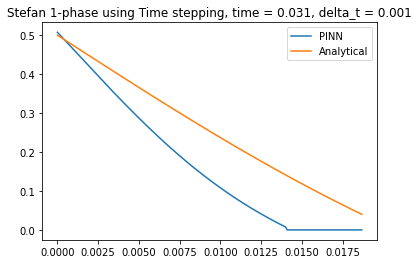

In [4]:
j = 30
i = 0
k = 201

plt.plot(x_test_np[i:k].detach().numpy(), T_store_pred[j][i:k])
plt.plot(x_test_np[i:k].detach().numpy(), T_store_an[j-1][i:k])
Title = "Stefan 1-phase using Time stepping, " + "time = " + str((j+1)*del_t) + ", delta_t = " + str(del_t)
plt.title(Title)
plt.legend(["PINN", "Analytical"])
plt.show()

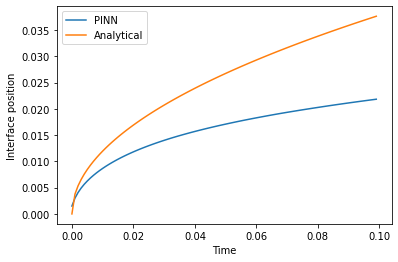

In [5]:
tp = []
for i in range(len(s_pred)):
    tp.append(s_pred[i][0])

i = 0
j = 100
plt.plot(t[i:j], tp[i:j])
plt.plot(t[i:j], s_an[i:j])
plt.legend(["PINN", "Analytical"])
plt.xlabel('Time')
plt.ylabel('Interface position')
plt.show()

In [6]:
s_an

[0,
 0.0037820840815613846,
 0.005348674602179501,
 0.006550761787761791,
 0.007564168163122769,
 0.008456997102991115,
 0.009264176164128148,
 0.010006453917347552,
 0.010697349204359002,
 0.011346252244684153,
 0.011960000000000009,
 0.012543753824115022,
 0.013101523575523586,
 0.013636498084185702,
 0.014151262841174295,
 0.014647948661843418,
 0.01512833632624554,
 0.015593932153244752,
 0.016046023806538506,
 0.016485722307499923,
 0.016913994205982233,
 0.017331686588442585,
 0.017739546781132844,
 0.018138238062171328,
 0.018528352328256302,
 0.018910420407806928,
 0.019284920533930147,
 0.01965228536328538,
 0.020012907834695108,
 0.020367146093647998,
 0.020715327658523797,
 0.021057752966544198,
 0.021394698408718014,
 0.02172641894100362,
 0.02205315034184461,
 0.022375111172908194,
 0.022692504489368315,
 0.023005519337758955,
 0.023314332072783068,
 0.023619107519125295,
 0.023920000000000025,
 0.024217154250654665,
 0.024510706232175387,
 0.02480078385857998,
 0.02508750

In [7]:
tp

[array([0.0015], dtype=float32),
 array([0.00301695], dtype=float32),
 array([0.00407571], dtype=float32),
 array([0.00492018], dtype=float32),
 array([0.00563648], dtype=float32),
 array([0.00626497], dtype=float32),
 array([0.00682855], dtype=float32),
 array([0.0073418], dtype=float32),
 array([0.00781463], dtype=float32),
 array([0.00825417], dtype=float32),
 array([0.00866561], dtype=float32),
 array([0.00905288], dtype=float32),
 array([0.00941904], dtype=float32),
 array([0.00976661], dtype=float32),
 array([0.01009769], dtype=float32),
 array([0.01041401], dtype=float32),
 array([0.01071691], dtype=float32),
 array([0.01100752], dtype=float32),
 array([0.01128685], dtype=float32),
 array([0.01155578], dtype=float32),
 array([0.01181513], dtype=float32),
 array([0.01206561], dtype=float32),
 array([0.01230793], dtype=float32),
 array([0.01254254], dtype=float32),
 array([0.01276991], dtype=float32),
 array([0.01299051], dtype=float32),
 array([0.01320475], dtype=float32),
 array